# *Inference  be using Hamiltonian Monte Carlo*

In [ ]:
!pip install seaborn pennylane qiskit pykalman arviz pymc hurst hmmlearn copulas arch PyWavelet tensorflow scipy statsmodels PyWavelets ruptures emcee

In [ ]:
!pip install yfinance

In [1]:
!pip install 

ERROR: You must give at least one requirement to install (see "pip help install")


In [1]:
# Importing required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, norm, jarque_bera
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import autocorrelation_plot
from arch import arch_model
from sklearn.covariance import EllipticEnvelope
from pykalman import KalmanFilter
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import ruptures as rpt
from hurst import compute_Hc
from arch import arch_model
from scipy.stats import genpareto, genextreme
import pywt  # For wavelet analysis
from copulas.multivariate import GaussianMultivariate, VineCopula
from copulas.visualization import scatter_2d
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from hmmlearn import hmm
from sklearn.model_selection import GridSearchCV, train_test_split

In [3]:
# Step 1 Data Preparation
np.random.seed(1234)
ticker = "^DJI"  # Define the ticker symbol for Dow Jones index
data = yf.download(ticker, start="1992-01-01", end="2024-07-30") 
data['Returns'] = data['Adj Close'].pct_change().dropna() 

print(f"Data shape: {data.shape}")
print(data.info())

lags = 20  # Number of lagged features
for lag in range(1, lags +1):
    data[f'Lag_{lag}'] = data['Returns'].shift(lag)
data = data.dropna()

data['Volatility'] = data['Returns'].rolling(window=21).std() 
data.dropna(inplace=True) 

X = data[['Returns'] + [f'Lag_{lag}' for lag in range(1, lags + 1)]].values  # Feature matrix

y = data['Volatility']* np.sqrt(252)  # 21-day rolling, annualized

# Standardize the returns data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale returns 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

forecast_horizon = len(y_test)
T = len(y_train)  # Length of time series

[*********************100%%**********************]  1 of 1 completed

Data shape: (8203, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8203 entries, 1992-01-02 to 2024-07-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8203 non-null   float64
 1   High       8203 non-null   float64
 2   Low        8203 non-null   float64
 3   Close      8203 non-null   float64
 4   Adj Close  8203 non-null   float64
 5   Volume     8203 non-null   int64  
 6   Returns    8202 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 512.7 KB
None


In [4]:
# Descriptive statistics of returns
print("Descriptive Statistics of Returns")
returns_stats = pd.DataFrame(X).describe()
returns_stats

Descriptive Statistics of Returns


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
count,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,...,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000
mean,0.000369,0.000370,0.000367,0.000368,0.000368,0.000369,0.000368,0.000371,0.000373,0.000372,...,0.000367,0.000368,0.000368,0.000367,0.000366,0.000366,0.000365,0.000367,0.000367,0.000366
std,0.011027,0.011027,0.011026,0.011026,0.011025,0.011025,0.011025,0.011026,0.011025,0.011025,...,0.011024,0.011024,0.011024,0.011023,0.011024,0.011024,0.011024,0.011025,0.011025,0.011025
min,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,...,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265,-0.129265
25%,-0.004402,-0.004402,-0.004402,-0.004402,-0.004402,-0.004402,-0.004402,-0.004398,-0.004391,-0.004398,...,-0.004402,-0.004402,-0.004402,-0.004402,-0.004408,-0.004408,-0.004412,-0.004412,-0.004412,-0.004420
50%,0.000551,0.000551,0.000551,0.000551,0.000551,0.000551,0.000551,0.000551,0.000552,0.000551,...,0.000550,0.000550,0.000550,0.000550,0.000550,0.000550,0.000549,0.000550,0.000550,0.000549
75%,0.005579,0.005579,0.005577,0.005579,0.005579,0.005579,0.005579,0.005582,0.005582,0.005579,...,0.005577,0.005577,0.005577,0.005577,0.005577,0.005577,0.005577,0.005579,0.005579,0.005579
max,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,...,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650,0.113650


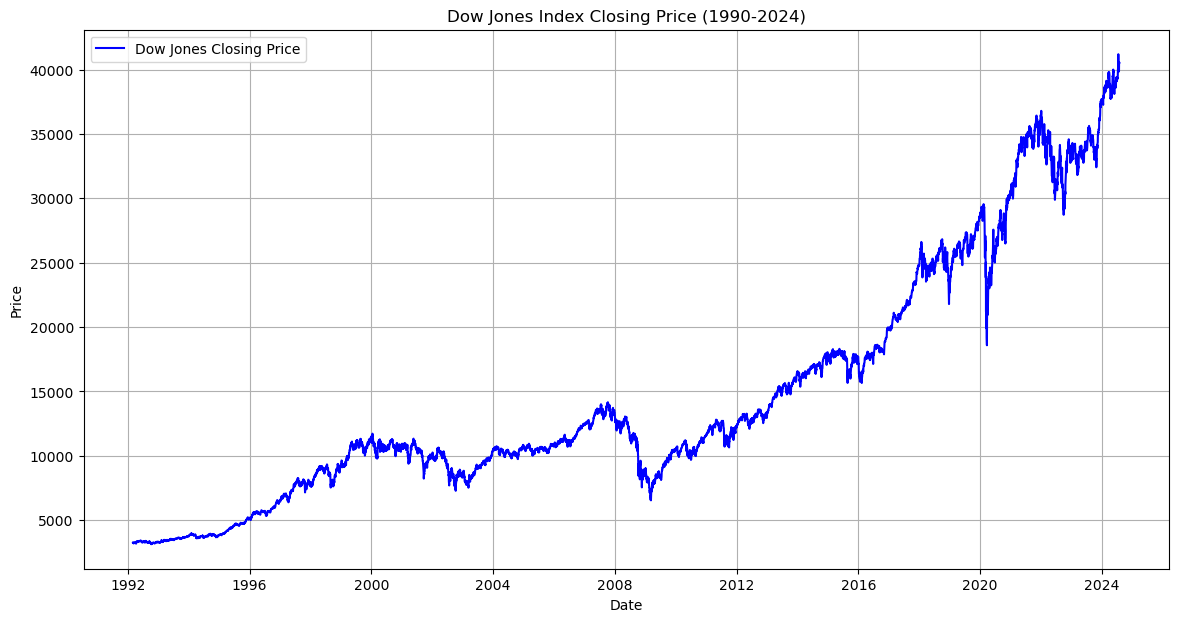

In [5]:
# Plotting the Closing Price of the Dow Jones Index
plt.figure(figsize=(14, 7))
plt.plot(data['Adj Close'], label='Dow Jones Closing Price', color='blue')
plt.title('Dow Jones Index Closing Price (1990-2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

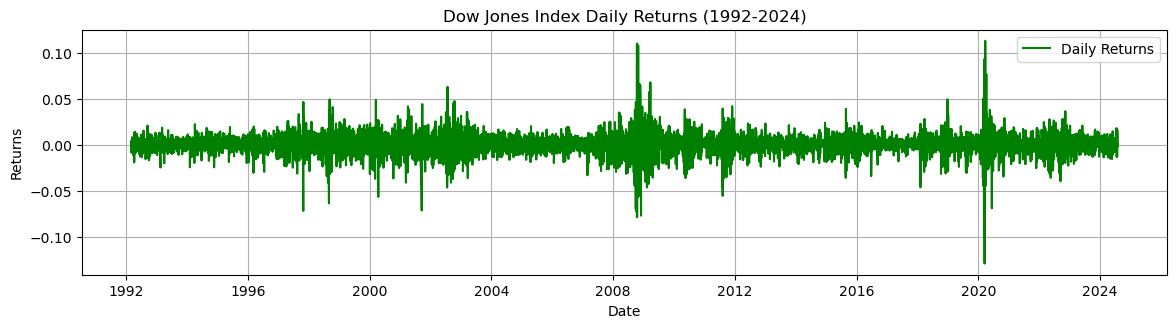

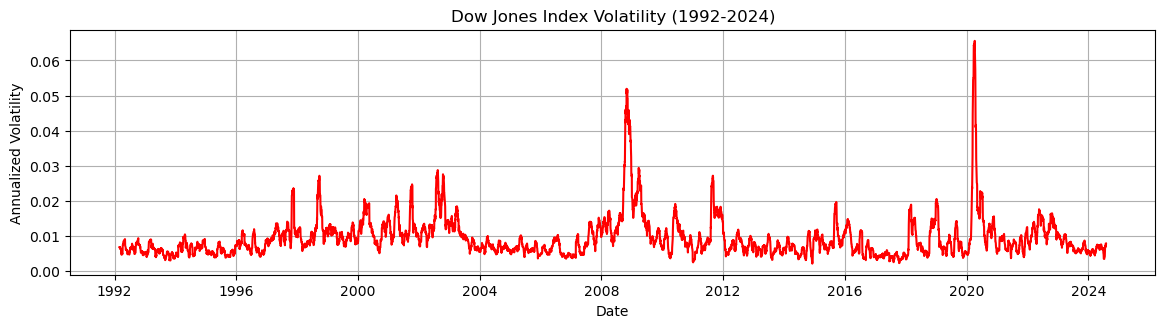

In [6]:
# Plotting the Daily Returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data['Returns'], color='green', label='Daily Returns')
plt.title('Dow Jones Index Daily Returns (1992-2024)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Volatility
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 2)
plt.plot(data['Volatility'], color='red', label='21-day Rolling Volatility')
plt.title('Dow Jones Index Volatility (1992-2024)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.show()

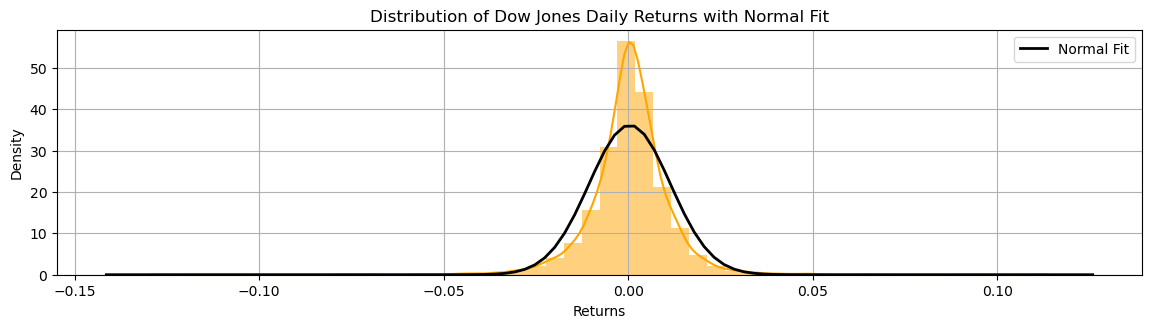

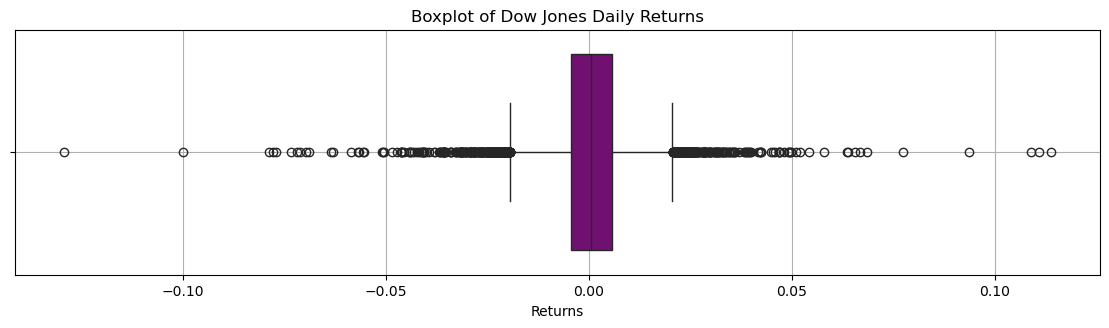

In [7]:
# Distribution Plot of Returns with Fitted Normal Curve
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
sns.histplot(data['Returns'], bins=50, kde=True, color='orange', stat="density", linewidth=0)
mu, std = norm.fit(data['Returns'].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Fit')
plt.title('Distribution of Dow Jones Daily Returns with Normal Fit')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

# Boxplot of Returns to Identify Outliers
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 2)
sns.boxplot(x=data['Returns'], color='purple')
plt.title('Boxplot of Dow Jones Daily Returns')
plt.grid(True)
plt.show()

In [8]:
# Skewness, Kurtosis, and Normality Test
returns_skewness = skew(data['Returns'].dropna())
returns_kurtosis = kurtosis(data['Returns'].dropna())
jb_stat, jb_p_value = jarque_bera(data['Returns'].dropna())

print(f"\nSkewness of Returns: {returns_skewness}")
print(f"Kurtosis of Returns: {returns_kurtosis}")
print(f"Jarque-Bera Test Statistic: {jb_stat}, p-value: {jb_p_value}")


Skewness of Returns: -0.16709590343688027
Kurtosis of Returns: 12.661038922292041
Jarque-Bera Test Statistic: 54553.98865612532, p-value: 0.0


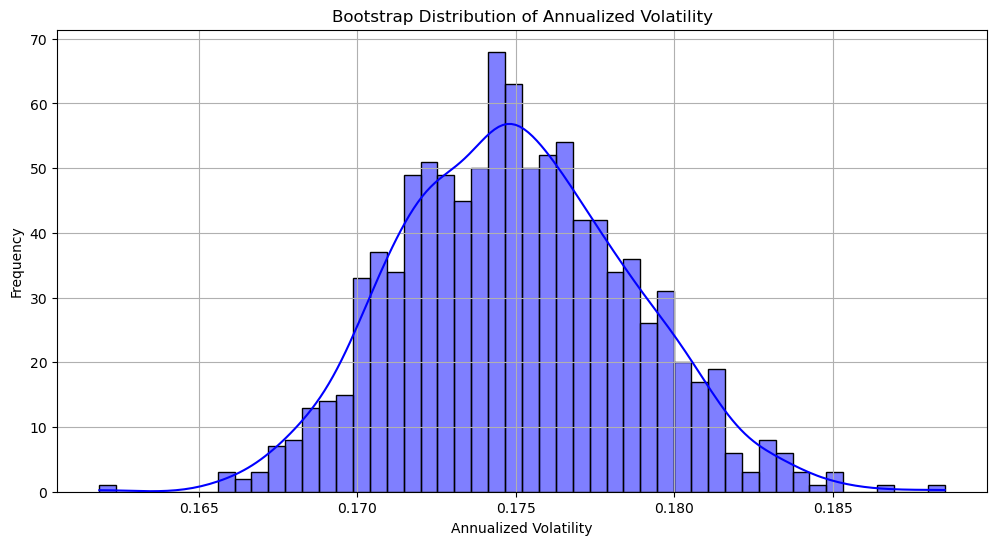

In [9]:
# Bootstrap Analysis to Test Volatility Stability
bootstrap_samples = np.random.choice(data['Returns'].dropna(), size=(1000, len(data['Returns'].dropna())), replace=True)
bootstrap_volatility = np.std(bootstrap_samples, axis=1) * np.sqrt(252)

plt.figure(figsize=(12, 6))
sns.histplot(bootstrap_volatility, bins=50, color='blue', kde=True)
plt.title('Bootstrap Distribution of Annualized Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

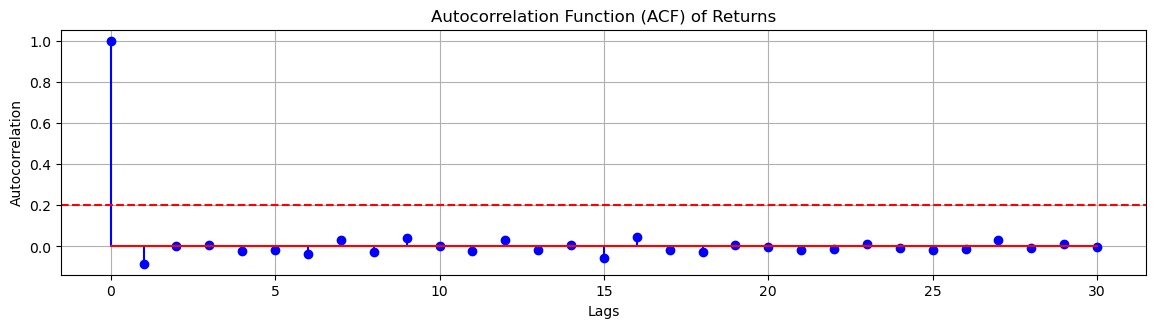

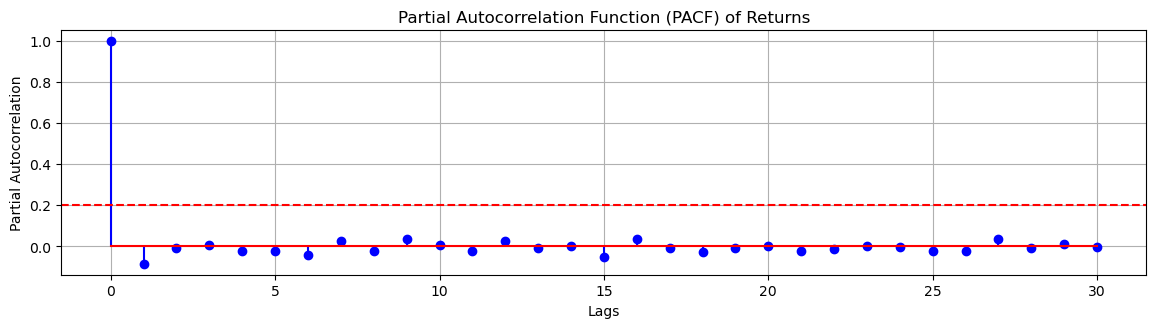

In [10]:
# Plotting ACF and PACF using statsmodels
lag_acf = acf(data['Returns'].dropna(), nlags=30)
lag_pacf = pacf(data['Returns'].dropna(), nlags=30)

# Plotting ACF
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.stem(lag_acf, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title('Autocorrelation Function (ACF) of Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.axhline(y=0.2, color='red', linestyle='--')
plt.grid(True)
plt.show()

# Plotting PACF
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 2)
plt.stem(lag_pacf, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title('Partial Autocorrelation Function (PACF) of Returns')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.axhline(y=0.2, color='red', linestyle='--')
plt.grid(True)
plt.show()

In [11]:
# Stationarity Test: Augmented Dickey-Fuller Test
adf_test = adfuller(data['Returns'].dropna())
print("\nADF Test Statistic: {:.6f}".format(adf_test[0]))
print("p-value: {:.6f}".format(adf_test[1]))

print('\nCritical Values:')
for key, value in adf_test[4].items():
    print(f'\t{key}: {value:.3f}')

print("\nConclusion: Returns are {}".format('stationary' if adf_test[1] < 0.05 else 'non-stationary'))


ADF Test Statistic: -17.522307
p-value: 0.000000

Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Conclusion: Returns are stationary


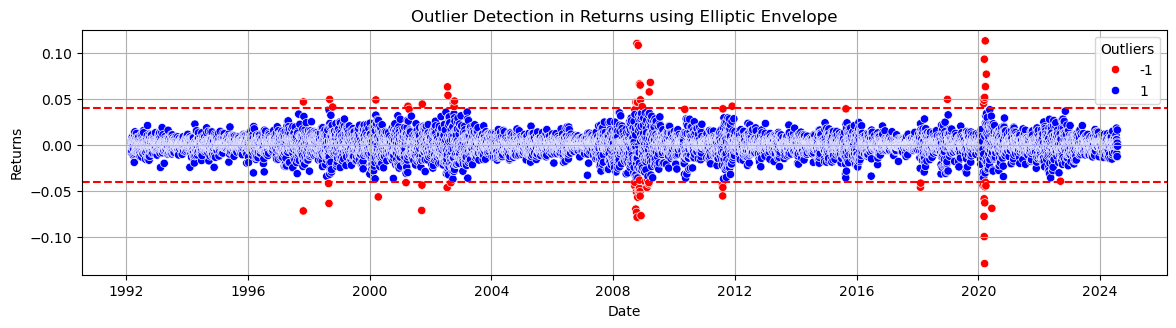

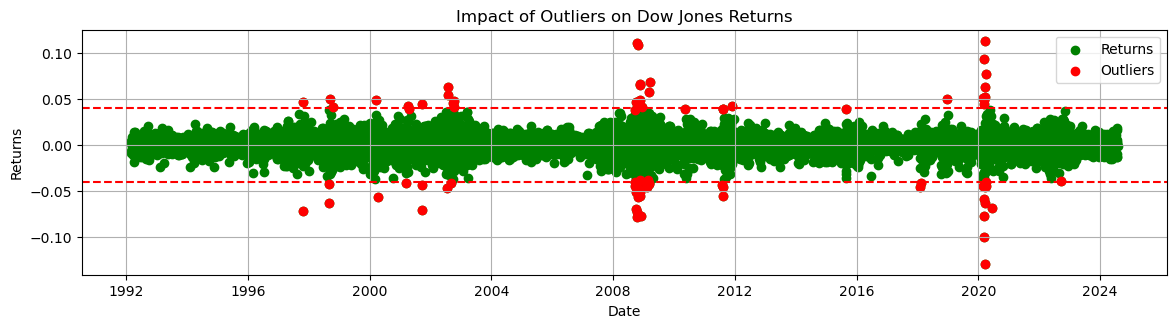

In [12]:
# Sensitivity Analysis: Impact of Outliers
# Detecting outliers using Elliptic Envelope
outlier_detector = EllipticEnvelope(contamination=0.01)
data.loc[:, 'Outliers'] = outlier_detector.fit_predict(data[['Returns']])

# Visualizing the Impact of Outliers
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
sns.scatterplot(x=data.index, y=data['Returns'], hue=data['Outliers'], palette={1: 'blue', -1: 'red'}, legend='full')
plt.title('Outlier Detection in Returns using Elliptic Envelope')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.axhline(y=0.04, color='red', linestyle='--')
plt.axhline(y=-0.04, color='red', linestyle='--')
plt.grid(True)
plt.show()

# Visualizing the Impact of Outliers
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 2)
plt.scatter(data.index, data['Returns'], color='green', label='Returns')
plt.scatter(data[data['Outliers'] == -1].index, data[data['Outliers'] == -1]['Returns'], color='red', label='Outliers')
plt.title('Impact of Outliers on Dow Jones Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.axhline(y=0.04, color='red', linestyle='--')
plt.axhline(y=-0.04, color='red', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

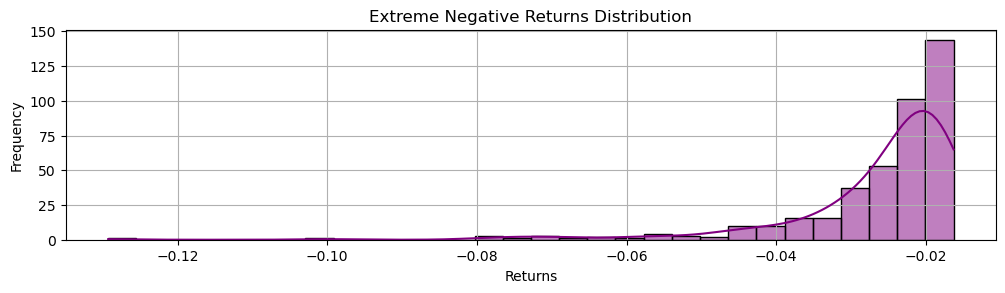

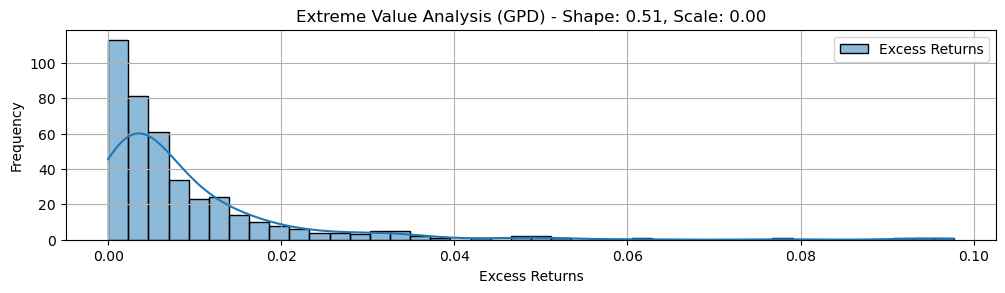

In [13]:

extreme_values = data['Returns'][data['Returns'] < data['Returns'].quantile(0.05)]
excesses = data['Returns'].dropna() - data['Returns'].dropna().quantile(0.95)  # Calculate excess over threshold
params = genpareto.fit(excesses[excesses > 0])

# Extreme Value Theory (EVT) for Tail Risk Analysis
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
sns.histplot(extreme_values, bins=30, color='purple', kde=True)
plt.title('Extreme Negative Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 4. Extreme Value Analysis - Generalized Pareto Distribution (GPD)
plt.figure(figsize=(12, 6))
plt.subplot(2,1,2)
sns.histplot(excesses[excesses > 0], kde=True, label='Excess Returns')
plt.title(f'Extreme Value Analysis (GPD) - Shape: {params[0]:.2f}, Scale: {params[1]:.2f}')
plt.xlabel('Excess Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# Step 6:  Hidden Markov Model for Volatility Clustering
# Prepare data for HMM
returns = data['Returns'].values.reshape(-1, 1)
returns = scaler.fit_transform(returns)
# Define HMM with 2 states (e.g., low and high volatility regimes)
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=15_000)
model.fit(returns)
# Predict the hidden states (volatility regimes)
hidden_states = model.predict(returns)

# Add hidden states to the DataFrame
data['Volatility_Regime'] = hidden_states

#  Map the hidden states to meaningful labels (optional)
# Assuming 0 = Low Volatility, 1 = High Volatility
data['Volatility_Regime_Label'] = np.where(data['Volatility_Regime'] == 0, 'Low Volatility', 'High Volatility')

NameError: name 'data' is not defined

In [ ]:
# Detecting structural breaks using the Binary Segmentation (Binseg) algorithm
algo = rpt.Binseg(model="rbf").fit(data['Returns'].dropna().values)
breaks = algo.predict(n_bkps=20)  # Specify the number of breakpoints you want to detect

# Plotting the detected structural breaks
plt.figure(figsize=(14, 5))
plt.plot(data['Returns'], color='blue', label='Returns')

# Adding vertical lines for each detected breakpoint
for bkpt in breaks[:-1]:  # Exclude the last breakpoint as it is usually the end of the series
    plt.axvline(data.index[bkpt], color='red', linestyle='--', label='Detected Breakpoint')

plt.title('Detected Structural Breaks in Dow Jones Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

In [ ]:
# Step 3: Plot the Volatility Regimes
plt.figure(figsize=(14, 7))
# Plot the hidden states over time
plt.plot(data.index, data['Volatility_Regime'], label='Volatility Regime', color='purple')

# Highlight different regimes with background color
for regime in data['Volatility_Regime'].unique():
    plt.fill_between(data.index, -0.5, 1.5, where=(data['Volatility_Regime'] == regime), 
                     color='green' if regime == 1 else 'yellow', alpha=0.3)

plt.title('Volatility Regimes Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility Regime')
plt.yticks([0, 1], ['Low Volatility', 'High Volatility'])
plt.legend()
plt.show()

In [8]:
# Detecting structural breaks using the Binary Segmentation (Binseg) algorithm
algo = rpt.Binseg(model="rbf").fit(data['Volatility'].dropna().values)
breaks = algo.predict(n_bkps=20)  # Specify the number of breakpoints you want to detect

# Plotting the detected structural breaks
plt.figure(figsize=(14, 5))
plt.plot(data['Volatility'], color='blue', label='Volatility')

# Adding vertical lines for each detected breakpoint
for bkpt in breaks[:-1]:  # Exclude the last breakpoint as it is usually the end of the series
    plt.axvline(data.index[bkpt], color='red', linestyle='--', label='Detected Breakpoint')

plt.title('Detected Structural Breaks in Dow Jones Returns')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

NameError: name 'rpt' is not defined

In [10]:
# Calculate downside metrics
returns = data['Returns'].dropna()

var_95 = np.percentile(returns, 5)
es_95 = returns[returns < var_95].mean()

# Calculate upside metrics
var_up_95 = np.percentile(returns, 95)
es_up_95 = returns[returns > var_up_95].mean()

print(f'95% Historical VaR: {var_95}')
print(f'95% Expected Shortfall: {es_95}')

print(f'95% Upside VaR: {var_up_95}')
print(f'95% Upside Expected Shortfall: {es_up_95}')

# Plot the distribution of returns
plt.figure(figsize=(12, 7))
sns.histplot(returns, kde=True, bins=50, color='blue', stat='density')

# Highlight the 95% Downside VaR
plt.axvline(var_95, color='red', linestyle='--', linewidth=2, label=f'95% Historical VaR: {var_95:.4f}')

# Shade the area for the Downside Expected Shortfall (bottom 5% of returns)
returns_bottom_5 = returns[returns < var_95]
plt.fill_betweenx(
    [0, np.histogram(returns_bottom_5, bins=50, density=True)[0].max()],
    var_95, min(returns),
    color='red', alpha=0.3, label=f'95% Expected Shortfall: {es_95:.4f}'
)

# Highlight the 95% Upside VaR
plt.axvline(var_up_95, color='green', linestyle='--', linewidth=2, label=f'95% Upside VaR: {var_up_95:.4f}')

# Shade the area for the Upside Expected Shortfall (top 5% of returns)
returns_top_5 = returns[returns > var_up_95]
plt.fill_between(
    np.linspace(var_up_95, max(returns), 100),
    0,
    np.histogram(returns_top_5, bins=50, density=True)[0].max(),
    color='orange', alpha=0.3, label=f'95% Upside Expected Shortfall: {es_up_95:.4f}'
)

# Add titles and labels
plt.title('Distribution of Returns with Downside and Upside Risk Metrics', fontsize=16)
plt.xlabel('Returns', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

NameError: name 'data' is not defined

Iteration:      1,   Func. Count:      5,   Neg. LLF: 479453.7361804823
Iteration:      2,   Func. Count:     13,   Neg. LLF: 14542.822271477678
Iteration:      3,   Func. Count:     20,   Neg. LLF: 9359.890410735456
Iteration:      4,   Func. Count:     24,   Neg. LLF: 9372.17430356624
Iteration:      5,   Func. Count:     29,   Neg. LLF: 9359.644850135763
Iteration:      6,   Func. Count:     33,   Neg. LLF: 9359.644824505507
Iteration:      7,   Func. Count:     36,   Neg. LLF: 9359.644830566474
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9359.644824505507
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7


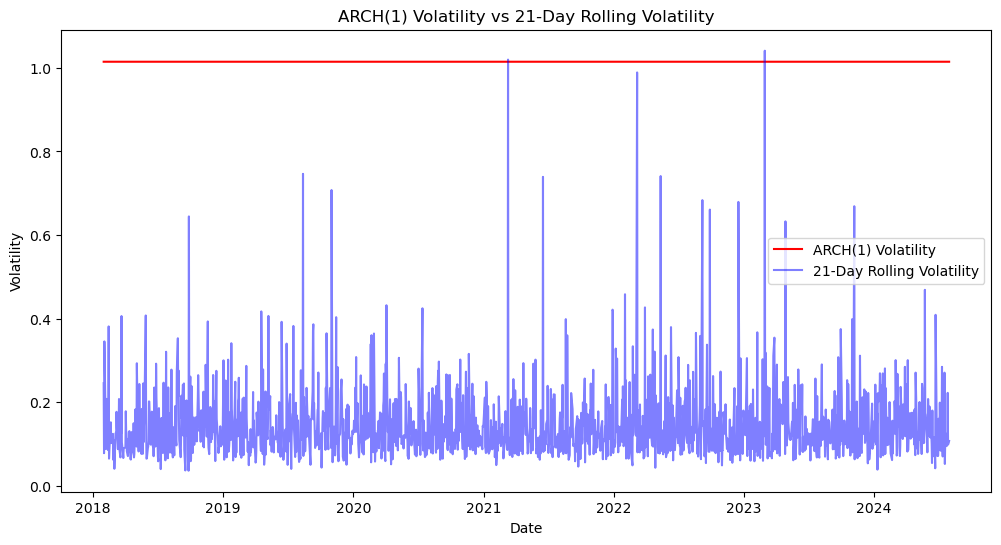

In [19]:
# 1. ARCH(1) Model
arch_model_ = arch_model(X_train[:,0], vol='ARCH', p=1)
arch_fit = arch_model_.fit()
arch_forecast = arch_fit.forecast(horizon=forecast_horizon)
arch_volatility = np.sqrt(arch_forecast.variance[-1:]).squeeze()

# Ensure proper slicing of the conditional_volatility
# Assuming you want to plot the volatility corresponding to y_test
volatility_length = len(arch_fit.conditional_volatility)
test_length = len(y_test)

# Correct the slicing if needed
# Example: if you want the last part of the conditional_volatility that matches y_test
if test_length <= volatility_length:
    volatility_to_plot = arch_fit.conditional_volatility[-test_length:]
else:
    # Handle cases where test length might be incorrect or exceeds available data
    raise ValueError("Test length exceeds available conditional volatility data")

# Ensure the x and y lengths match for plotting
if len(data.index[-test_length:]) == len(volatility_to_plot):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-test_length:], volatility_to_plot, color='red', label='ARCH(1) Volatility')
    plt.plot(data.index[-test_length:], y_test, color='blue', label='21-Day Rolling Volatility', alpha=0.5)
    plt.title('ARCH(1) Volatility vs 21-Day Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
else:
    print("Mismatch in lengths of x and y data for plotting.")


Iteration:      1,   Func. Count:      6,   Neg. LLF: 39058.26170542513
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8151889525.39411
Iteration:      3,   Func. Count:     23,   Neg. LLF: 79904.54974057643
Iteration:      4,   Func. Count:     29,   Neg. LLF: 9359.62318501843
Iteration:      5,   Func. Count:     34,   Neg. LLF: 9835.28105249416
Iteration:      6,   Func. Count:     40,   Neg. LLF: 9543.573695653831
Iteration:      7,   Func. Count:     46,   Neg. LLF: 9438.052678466363
Iteration:      8,   Func. Count:     52,   Neg. LLF: 9383.219791045827
Iteration:      9,   Func. Count:     59,   Neg. LLF: 9494.047918124379
Iteration:     10,   Func. Count:     65,   Neg. LLF: 9359.35893648423
Iteration:     11,   Func. Count:     71,   Neg. LLF: 9359.348404311024
Iteration:     12,   Func. Count:     76,   Neg. LLF: 9359.347022798618
Iteration:     13,   Func. Count:     81,   Neg. LLF: 9359.346722926075
Iteration:     14,   Func. Count:     86,   Neg. LLF: 9359.346718446

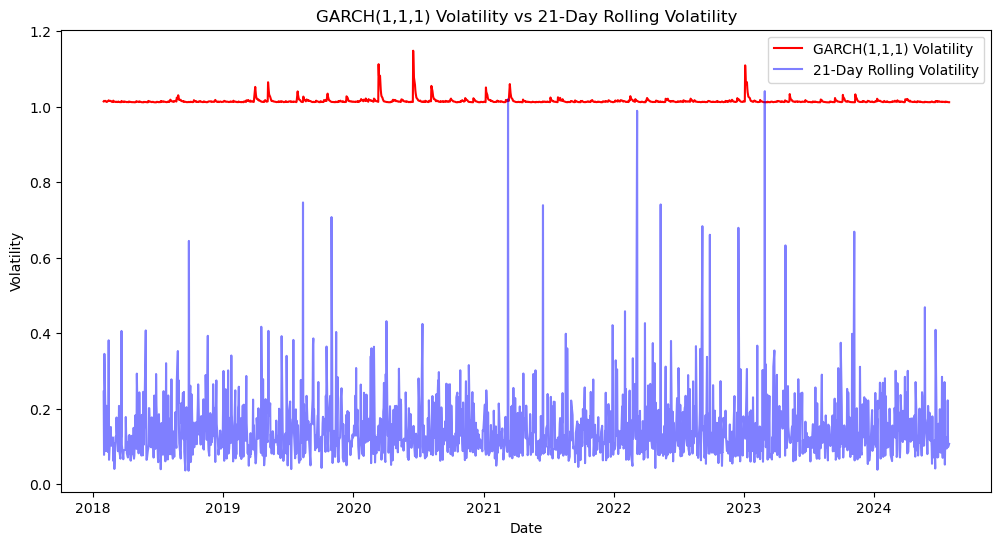

In [20]:
# 2. GARCH(1,1) Model
garch_model = arch_model(X_train[:,0], vol='GARCH', p=1, q=1)
garch_fit = garch_model.fit()
# Forecast the volatility over the specified horizon
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)

# Ensure proper slicing of the conditional_volatility
# Assuming you want to plot the volatility corresponding to y_test
volatility_length = len(garch_fit.conditional_volatility)
test_length = len(y_test)

# Correct the slicing if needed
# Example: if you want the last part of the conditional_volatility that matches y_test
if test_length <= volatility_length:
    volatility_to_plot = garch_fit.conditional_volatility[-test_length:]
else:
    # Handle cases where test length might be incorrect or exceeds available data
    raise ValueError("Test length exceeds available conditional volatility data")

# Ensure the x and y lengths match for plotting
if len(data.index[-test_length:]) == len(volatility_to_plot):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-test_length:], volatility_to_plot, color='red', label='GARCH(1,1,1) Volatility')
    plt.plot(data.index[-test_length:], y_test, color='blue', label='21-Day Rolling Volatility', alpha=0.5)
    plt.title('GARCH(1,1,1) Volatility vs 21-Day Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
else:
    print("Mismatch in lengths of x and y data for plotting.")


Iteration:      1,   Func. Count:      7,   Neg. LLF: 50762.66684668137
Iteration:      2,   Func. Count:     17,   Neg. LLF: 129961812484.8378
Iteration:      3,   Func. Count:     27,   Neg. LLF: 65214160923.46365
Iteration:      4,   Func. Count:     36,   Neg. LLF: 19286.236533773517
Iteration:      5,   Func. Count:     46,   Neg. LLF: 45794.5348867117
Iteration:      6,   Func. Count:     53,   Neg. LLF: 9355.106268328735
Iteration:      7,   Func. Count:     60,   Neg. LLF: 9350.752133335882
Iteration:      8,   Func. Count:     66,   Neg. LLF: 9350.75195779781
Iteration:      9,   Func. Count:     72,   Neg. LLF: 9350.75195604119
Iteration:     10,   Func. Count:     77,   Neg. LLF: 9350.751956041233
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9350.75195604119
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10


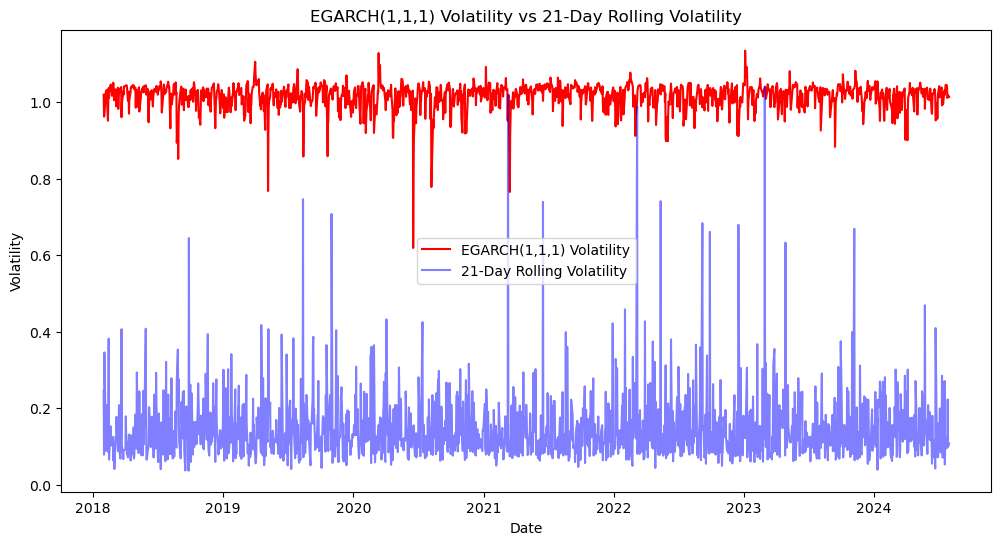

In [21]:
# 3. EGARCH(1,1,1) Model
egarch_model = arch_model(X_train[:,0], vol='EGARCH', p=1, q=1, o=1)
egarch_fit = egarch_model.fit()
egarch_forecast = egarch_fit.forecast(horizon=forecast_horizon, method='simulation')
egarch_volatility = np.sqrt(egarch_forecast.variance[-1:]).squeeze()

# Ensure proper slicing of the conditional_volatility
# Assuming you want to plot the volatility corresponding to y_test
volatility_length = len(egarch_fit.conditional_volatility)
test_length = len(y_test)

# Correct the slicing if needed
# Example: if you want the last part of the conditional_volatility that matches y_test
if test_length <= volatility_length:
    volatility_to_plot = egarch_fit.conditional_volatility[-test_length:]
else:
    # Handle cases where test length might be incorrect or exceeds available data
    raise ValueError("Test length exceeds available conditional volatility data")

# Ensure the x and y lengths match for plotting
if len(data.index[-test_length:]) == len(volatility_to_plot):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-test_length:], volatility_to_plot, color='red', label='EGARCH(1,1,1) Volatility')
    plt.plot(data.index[-test_length:], y_test, color='blue', label='21-Day Rolling Volatility', alpha=0.5)
    plt.title('EGARCH(1,1,1) Volatility vs 21-Day Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
else:
    print("Mismatch in lengths of x and y data for plotting.")


Iteration:      1,   Func. Count:      9,   Neg. LLF: 25800.5680476345
Iteration:      2,   Func. Count:     21,   Neg. LLF: 18881.946524173385
Iteration:      3,   Func. Count:     32,   Neg. LLF: 688824742.2011101
Iteration:      4,   Func. Count:     42,   Neg. LLF: 9355.665417971672
Iteration:      5,   Func. Count:     50,   Neg. LLF: 9353.614096378418
Iteration:      6,   Func. Count:     58,   Neg. LLF: 9353.578008349828
Iteration:      7,   Func. Count:     66,   Neg. LLF: 9353.570715486825
Iteration:      8,   Func. Count:     74,   Neg. LLF: 9353.569370276558
Iteration:      9,   Func. Count:     82,   Neg. LLF: 9353.56924636511
Iteration:     10,   Func. Count:     90,   Neg. LLF: 9353.569220124657
Iteration:     11,   Func. Count:     98,   Neg. LLF: 9353.569216782551
Iteration:     12,   Func. Count:    106,   Neg. LLF: 9353.569213366889
Iteration:     13,   Func. Count:    114,   Neg. LLF: 9353.56921412242
Optimization terminated successfully    (Exit mode 0)
            

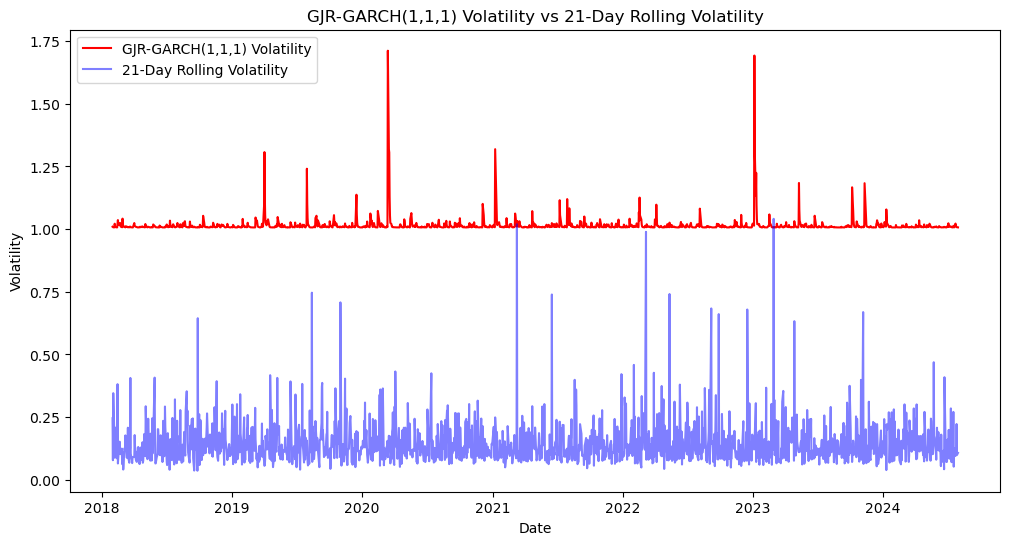

In [22]:
# 4  GJR-GARCH(2,1,2) Model
gjr_garch_model = arch_model(X_train[:,0], vol='GARCH', p=2, q=1, o=2)
gjr_garch_fit = gjr_garch_model.fit()
gjr_garch_forecast = gjr_garch_fit.forecast(horizon=forecast_horizon)
gjr_garch_volatility = np.sqrt(gjr_garch_forecast.variance[-1:]).squeeze()

# Ensure proper slicing of the conditional_volatility
# Assuming you want to plot the volatility corresponding to y_test
volatility_length = len(gjr_garch_fit.conditional_volatility)
test_length = len(y_test)

# Correct the slicing if needed
# Example: if you want the last part of the conditional_volatility that matches y_test
if test_length <= volatility_length:
    volatility_to_plot = gjr_garch_fit.conditional_volatility[-test_length:]
else:
    # Handle cases where test length might be incorrect or exceeds available data
    raise ValueError("Test length exceeds available conditional volatility data")

# Ensure the x and y lengths match for plotting
if len(data.index[-test_length:]) == len(volatility_to_plot):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-test_length:], volatility_to_plot, color='red', label='GJR-GARCH(1,1,1) Volatility')
    plt.plot(data.index[-test_length:], y_test, color='blue', label='21-Day Rolling Volatility', alpha=0.5)
    plt.title('GJR-GARCH(1,1,1) Volatility vs 21-Day Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
else:
    print("Mismatch in lengths of x and y data for plotting.")


In [7]:
# Define the parameter grid for SVR
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'epsilon': [0.01, 0.1, 0.5, 1, 10],
    'gamma': ['scale', 'auto']
}

# Initialize the SVR model
svr = SVR(kernel='rbf')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')
 
# Predict with the best model
y_pred = best_model.predict(X_test)

# Evaluate performance
mse_best = mean_squared_error(y_test, y_pred)
mae_best = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error of Model: {mse_best}')
print(f'Mean Absolute Error of Model: {mae_best}')

Best Parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 'scale'}
Mean Squared Error of Model: 0.0012079863917872566
Mean Absolute Error of Model: 0.012752090549272259


### B

In [ ]:


# Initialize a list to store the results
results = []

# Define the range of samples
sample_range = np.arange(5000, 50001, 500)  # From 5000 to 50000 in steps of 100

for samples in sample_range:
    tune_start = samples // 2  # Start tune at half the samples
    tune_range = range(tune_start, samples + 1, 500)  # Increment by 50 up to samples
    
    for tune in tune_range:
        with pm.Model() as model:
            mu = pm.Normal("mu", mu=0, sigma=1)
            phi = pm.Beta("phi", alpha=2, beta=2)
            sigma_eta = pm.Uniform("sigma_eta", lower=0, upper=1)

            # Log-volatility process
            h = pm.AR("h", phi, sigma=sigma_eta, init_dist=pm.Normal.dist(0, 1), shape=len(y_test))

            # Observations
            y_obs = pm.Normal("y_obs", mu=mu, sigma=pm.math.exp(h / 2), observed=y_pred)

            step = pm.HamiltonianMC()
            trace = pm.sample(samples, tune=tune, chains=4, cores=4, step=step, 
                              return_inferencedata=True, random_seed=1234)

        # Check for convergence using Gelman-Rubin statistic
        rhat = az.rhat(trace)
        if np.all(rhat < 1.1):  # Common threshold for convergence
            results.append((samples, tune, rhat))

# Convert results to a structured format
results_df = pd.DataFrame(results, columns=["samples", "tune", "rhat"])
print(results_df)


Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 183 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_000 tune and 5_000 draw iterations (12_000 + 20_000 draws total) took 166 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_500 tune and 5_000 draw iterations (14_000 + 20_000 draws total) took 162 seconds.
There were 2127 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 179 seconds.
There were 1411 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_500 tune and 5_000 draw iterations (18_000 + 20_000 draws total) took 182 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 174 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 2_750 tune and 5_500 draw iterations (11_000 + 22_000 draws total) took 165 seconds.
There were 2981 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_250 tune and 5_500 draw iterations (13_000 + 22_000 draws total) took 185 seconds.
There were 883 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_750 tune and 5_500 draw iterations (15_000 + 22_000 draws total) took 199 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_250 tune and 5_500 draw iterations (17_000 + 22_000 draws total) took 5511 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_750 tune and 5_500 draw iterations (19_000 + 22_000 draws total) took 274 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Sampling 4 chains for 5_250 tune and 5_500 draw iterations (21_000 + 22_000 draws total) took 5386 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 229 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_500 tune and 6_000 draw iterations (14_000 + 24_000 draws total) took 419 seconds.
There were 2355 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_000 tune and 6_000 draw iterations (16_000 + 24_000 draws total) took 328 seconds.
There were 1897 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_500 tune and 6_000 draw iterations (18_000 + 24_000 draws total) took 375 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 5_000 tune and 6_000 draw iterations (20_000 + 24_000 draws total) took 396 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 5_500 tune and 6_000 draw iterations (22_000 + 24_000 draws total) took 413 seconds.
There were 2407 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 6_000 tune and 6_000 draw iterations (24_000 + 24_000 draws total) took 430 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_250 tune and 6_500 draw iterations (13_000 + 26_000 draws total) took 340 seconds.
There were 908 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_750 tune and 6_500 draw iterations (15_000 + 26_000 draws total) took 203 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_250 tune and 6_500 draw iterations (17_000 + 26_000 draws total) took 237 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_750 tune and 6_500 draw iterations (19_000 + 26_000 draws total) took 260 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 5_250 tune and 6_500 draw iterations (21_000 + 26_000 draws total) took 270 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 5_750 tune and 6_500 draw iterations (23_000 + 26_000 draws total) took 260 seconds.
There were 2330 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 6_250 tune and 6_500 draw iterations (25_000 + 26_000 draws total) took 268 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 3_500 tune and 7_000 draw iterations (14_000 + 28_000 draws total) took 238 seconds.
There were 2683 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_000 tune and 7_000 draw iterations (16_000 + 28_000 draws total) took 204 seconds.
There were 2453 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 4_500 tune and 7_000 draw iterations (18_000 + 28_000 draws total) took 264 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 5_000 tune and 7_000 draw iterations (20_000 + 28_000 draws total) took 273 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 5_500 tune and 7_000 draw iterations (22_000 + 28_000 draws total) took 294 seconds.
There were 3190 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 6_000 tune and 7_000 draw iterations (24_000 + 28_000 draws total) took 251 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 6_500 tune and 7_000 draw iterations (26_000 + 28_000 draws total) took 298 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Sampling 4 chains for 7_000 tune and 7_000 draw iterations (28_000 + 28_000 draws total) took 266 seconds.
There were 2277 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


In [13]:
# Bayesian Stochastic Volatility Model with Hamiltonian Monte Carlo
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    phi = pm.Beta("phi", alpha=2, beta=2)
    sigma_eta = pm.Uniform("sigma_eta", lower=0,upper=1)

    # Log-volatility process
    h = pm.AR("h", phi, sigma=sigma_eta, init_dist=pm.Normal.dist(0, 1), shape=len(y_test))

    # Observations
    y_obs = pm.Normal("y_obs", mu=mu, sigma=pm.math.exp(h / 2), observed=y_pred)

    step=pm.HamiltonianMC()
    trace = pm.sample(20_000, tune=16_000, chains=4, cores=4, step=step, return_inferencedata=True, random_seed=1234)
    

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Output()

Sampling 4 chains for 16_000 tune and 20_000 draw iterations (64_000 + 80_000 draws total) took 203 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# Function to run the model
def run_model(samples, tune):
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=1)
        phi = pm.Beta("phi", alpha=2, beta=2)
        sigma_eta = pm.Uniform("sigma_eta", lower=0, upper=1)

        # Log-volatility process
        h = pm.AR("h", phi, sigma=sigma_eta, init_dist=pm.Normal.dist(0, 1), shape=len(y_test))

        # Observations
        y_obs = pm.Normal("y_obs", mu=mu, sigma=pm.math.exp(h / 2), observed=y_pred)

        step = pm.HamiltonianMC()
        trace = pm.sample(samples, tune=tune, chains=4, cores=4, step=step, return_inferencedata=True, random_seed=1234)
    
    return trace

# Define the range of samples and tunes
sample_sizes = range(5000, 50001, 5000)
results = []

# Iterate over the sample sizes and corresponding tune values
for samples in sample_sizes:
    tune = samples // 2  # Tune is at least half the sample size
    trace = run_model(samples, tune)
    
    # Check for convergence (using R-hat diagnostic)
    rhat = pm.summary(trace)["r_hat"].max()
    converged = rhat < 1.01  # Common threshold for convergence
    
    results.append({"samples": samples, "tune": tune, "converged": converged})

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)
print(results_df)


Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Output()

Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 74 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 102 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Output()

Sampling 4 chains for 7_500 tune and 15_000 draw iterations (30_000 + 60_000 draws total) took 134 seconds.
There were 5802 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Output()

Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 171 seconds.
There were 10371 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Output()

Sampling 4 chains for 12_500 tune and 25_000 draw iterations (50_000 + 100_000 draws total) took 194 seconds.
There were 4828 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mu, phi, sigma_eta, h]


Output()

In [15]:
# Summary including ESS and R-hat values
summary = az.summary(trace)
print("\n Summary of the trace with convergence diagnostics:")
print(summary)


 Summary of the trace with convergence diagnostics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
h[0]      -2.537  0.684  -3.778   -1.217      0.020    0.014    1177.0   
h[1]      -2.935  0.664  -4.097   -1.646      0.014    0.010    2160.0   
h[2]      -3.230  0.619  -4.377   -2.057      0.010    0.007    3734.0   
h[3]      -3.620  0.657  -4.854   -2.389      0.010    0.007    4281.0   
h[4]      -3.935  0.680  -5.220   -2.670      0.011    0.008    3718.0   
...          ...    ...     ...      ...        ...      ...       ...   
h[1631]   -5.433  0.691  -6.708   -4.122      0.009    0.007    5577.0   
h[1632]   -5.473  0.792  -6.972   -3.990      0.010    0.007    5841.0   
mu         0.127  0.003   0.122    0.132      0.000    0.000     126.0   
phi        0.996  0.002   0.992    0.999      0.000    0.000     316.0   
sigma_eta  0.423  0.061   0.319    0.545      0.008    0.006      59.0   

           ess_tail  r_hat  
h[0]         6814.0   1.00  


In [26]:
with model:
    ppc = pm.sample_posterior_predictive(trace)
    pm.set_data({"y_obs": y_test})
    forecast_trace =pm.sample_posterior_predictive(trace)

Sampling: [y_obs]


Output()

TypeError: The variable `y_obs` must be a `SharedVariable` (created through `pm.Data()` to allow updating.) The current type is: <class 'pytensor.tensor.variable.TensorVariable'>

In [39]:
pm.set_data

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 28000)
Coordinates:
  * chain               (chain) int32 0 1 2 3
  * draw                (draw) int32 0 1 2 3 4 ... 27995 27996 27997 27998 27999
Data variables: (12/15)
    accept              (chain, draw) float64 0.6064 0.06233 ... 0.01323 0.3472
    accepted            (chain, draw) bool True False False ... False False True
    diverging           (chain, draw) bool False False False ... False False
    energy              (chain, draw) float64 80.42 172.8 ... -470.0 -490.9
    energy_error        (chain, draw) float64 0.5003 2.775 ... 4.325 1.058
    largest_eigval      (chain, draw) float64 nan nan nan nan ... nan nan nan
    ...                  ...
    perf_counter_diff   (chain, draw) float64 0.003921 0.003776 ... 0.00382
    perf_counter_start  (chain, draw) float64 4.207e+03 4.207e+03 ... 4.342e+03
    process_time_diff   (chain, draw) float64 0.0 0.0 0.0 ... 0.0 0.01562 0.0
    smallest_eigval     (chain, draw) float64 nan nan nan nan ... nan nan nan
    step_size           (chain, draw) float64 0.1777 0.1777 ... 0.1515 0.1515
    step_size_bar       (chain, draw) float64 0.1783 0.1783 ... 0.1757 0.1757
Attributes:
    created_at:                 2024-09-20T11:12:04.724687+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              280.31645226478577
    tuning_steps:               24000

In [ ]:
# Trace plots
phi = trace.posterior['phi'].mean().values
sigma_eta = trace.posterior['sigma_eta'].mean().values
h = trace.posterior['h'].mean(dim=('chain', 'draw')).values

var_names=["mu", "phi", "sigma_eta"]
for var in var_names:
    az.plot_trace(trace, var)
    plt.show()

# Posterior Predictive Plot
az.plot_ppc(ppc)
plt.legend(loc='upper right')  
plt.show()

In [46]:
# Forecasting (using the last observed data)
h_estimated = np.mean(ppc.posterior_predictive['y_obs'][-forecast_horizon:], axis=0)
print(h_estimated)
print("\n Posterior predictive check complete.")

<xarray.DataArray 'y_obs' (draw: 50000, y_obs_dim_2: 1633)>
array([[ 3.26660702e-01, -2.77260300e-02,  1.29950532e-01, ...,
         8.39351618e-02,  1.43556840e-01,  8.84078201e-02],
       [-1.18213940e-02,  1.39108703e-01,  3.09168191e-01, ...,
         1.41083888e-01,  1.22881347e-01,  1.28757882e-01],
       [ 1.34509262e-01,  1.87947240e-01,  1.46621789e-01, ...,
         1.31541575e-01,  1.23447148e-01,  1.32500432e-01],
       ...,
       [ 1.74934049e-01,  1.02202792e-01,  3.24418325e-01, ...,
         1.54465890e-01,  9.64054384e-02,  1.09303102e-01],
       [ 6.58463848e-03,  1.70957451e-04,  1.40888377e-01, ...,
         1.44328681e-01,  1.67877336e-01,  1.47749584e-01],
       [ 2.40635374e-01,  2.19313809e-01,  2.12695695e-01, ...,
         2.04325474e-01,  1.88050017e-01,  1.21111489e-01]])
Coordinates:
  * draw         (draw) int32 0 1 2 3 4 5 ... 49995 49996 49997 49998 49999
  * y_obs_dim_2  (y_obs_dim_2) int32 0 1 2 3 4 5 ... 1628 1629 1630 1631 1632

 Posterior pred

In [47]:
# Initialize the Kalman Filter
def initialize_kalman_filter():
    kf = KalmanFilter(
        initial_state_mean=0,
        initial_state_covariance=1,
        transition_matrices=np.array([[1]]),
        observation_matrices=np.array([[1]]),
        transition_covariance=1e-5,  # Initial value for process noise
        observation_covariance=1e-5  # Initial value for measurement noise
    )
    return kf

# Adaptive Kalman Filter function
def adaptive_kalman_filter(kf, observations):
    filtered_state_means = []
    filtered_state_covariances = []
    
    # Initialize process noise and measurement noise
    Q = kf.transition_covariance
    R = kf.observation_covariance
    
    # Store recent innovations for adaptive noise estimation
    innovation_history = []
    window_size = 5
    
    for i, obs in enumerate(observations):
        # Perform one step of the Kalman filter
        filtered_state_mean, filtered_state_covariance = kf.filter_update(
            filtered_state_means[-1] if filtered_state_means else kf.initial_state_mean,
            filtered_state_covariances[-1] if filtered_state_covariances else kf.initial_state_covariance,
            observation=obs
        )
        
        # Store results
        filtered_state_means.append(filtered_state_mean)
        filtered_state_covariances.append(filtered_state_covariance)
        
        # Innovation: Difference between predicted observation and actual observation
        predicted_observation = filtered_state_mean  # Assuming observation matrix is identity
        innovation = obs - predicted_observation
        
        # Add innovation to the history
        innovation_history.append(innovation)
        
        # Adapt Measurement Noise R (based on rolling variance of innovation)
        if len(innovation_history) >= window_size:
            R = np.var(innovation_history[-window_size:])  # Adapt R based on the variance of recent innovations
        
        # Adapt Process Noise Q (optional but recommended for full AKF)
        # For example, Q could be adapted based on the variance of the filtered state
        Q = np.var(filtered_state_means[-window_size:]) if len(filtered_state_means) >= window_size else Q
        
        # Update the Kalman filter's covariance matrices in place
        kf.transition_covariance = Q
        kf.observation_covariance = R

    return np.array(filtered_state_means), np.array(filtered_state_covariances)

kf = initialize_kalman_filter()
h_filtered, P_filtered = adaptive_kalman_filter(kf, h)

h_filtered = h_filtered.squeeze()